Computational Magnetic Resonance Imaging (CMRI) 2023/2024 Winter semester

- Author: Jinho Kim
- Email: <jinho.kim@fau.de>
- Last update : Nov. 22. 2023

# Lab09: Machine learning in MRI and neural network architecture design

## Learning objecdtives
- Get familiar with designing and training neural networks in Pytorch
- Examine effects of dropping data on neural network performance
- Learn about effects of over and underfitting

## Import packages

In [145]:
import utils
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as data_utils
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [146]:
# unzip data.zip
# f = zipfile.ZipFile("data.zip", "r")
# for file in f.namelist():
#     f.extract(file, "")
# f.close()

## 1. Diffusion Data Classification
The goal is to classify labels of brain tissue pixel by pixel based on quantitative diffusion parameters.

### 1.1 Prepare training data
Entries in the CVS file 
1. sample
2. row
3. column
4. slice
5. T1 weighted anatomical Image
6. FA (Fractional Anisotropy)
7. MD (Mean Diffusivity)
8. AD (Azial Diffusivity)
9. RD (Radial Diffusivity)
10. Label (class)

#### 1.1.1 Load data
- Label 1: Thalamus
- Label 2: Corpus callosum (CC)
- Label 3: Cortical white matter (Cortical WM)

In [147]:
data = utils.load_data_ex1()

#### 1.1.2.	Train set: 3 / Test set: 1

In [148]:
# split the data: train and validation
train_data = np.concatenate(data[:3], axis=0)   # 17918, 10
# train_data = np.concatenate((train_data, data[-1]), axis=0)
test_data = data[-1]   # 5781, 10 23699
print(train_data.shape)
print(test_data.shape)
print(data[0].shape)
print(data[1].shape)
print(data[2].shape)
print(data[3].shape)

(17918, 10)
(5781, 10)
(5744, 10)
(6145, 10)
(6029, 10)
(5781, 10)


#### 1.1.3.	What features would you use for training from the data? 


In [149]:
# Define input and labels for training and test sets
# input_train, label_train, input_test, label_test
# set(train_data[:, -1])  # 1, 2, 3 -> 0, 1, 2
# set(label_train)

input_train = train_data[:, 4: 9].astype(float)   # 5 features in our data, 17918, 5 
label_train = train_data[:, -1] - 1

input_test = test_data[:, 4: 9].astype(float)    # 5781, 5
label_test = test_data[:, -1] - 1

nSamples = np.size(input_train, axis=0)   # Your code here ...
nSamples_test = np.size(input_test, axis=0)   # Your code here ...
nClasses = len(set(label_train))   # Your code here ...
nFeatures = np.size(input_train, axis=1)   # Your code here ...

print(f"Number of samples in training set: {nSamples}")
print(f"Number of samples in test set: {nSamples_test}")
print(f"Number of features: {nFeatures}")
print(f"Number of classes: {nClasses}")

Number of samples in training set: 17918
Number of samples in test set: 5781
Number of features: 5
Number of classes: 3


####  1.1.4.	Training data
- Normalize
  - Use the same normalization factor for the same feature. 

In [150]:
# Your code here ...
# normalize input training data and test data
for n in range(nFeatures):
    norm_factor = np.max(input_train[:, n])
    # min_factor = np.min(input_train[:, n])
    input_train[:, n] = (input_train[:, n]) / (norm_factor)
    input_test[:, n] = (input_test[:, n]) / (norm_factor)

- Separate training (0.8) and validation (0.2) set.


In [151]:
# Seperate training data into training and validation sets
# Your code here ...
# split_ratio = 0.8
# setsize_train = np.ceil(nSamples * split_ratio).astype(int)

# x_train = input_train[:setsize_train, :]
# y_train = label_train[:setsize_train]

# x_val = input_train[setsize_train:, :]
# y_val = label_train[setsize_train:]

# x_train = input_train[(nSamples - setsize_train):, :]
# y_train = label_train[(nSamples - setsize_train):]

# x_val = input_train[:(nSamples - setsize_train), :]
# y_val = label_train[:(nSamples - setsize_train):]

x_train, x_val, y_train, y_val = train_test_split(input_train, label_train, test_size=0.2, random_state=123)


- Generate dataloaders.
  - Batch size: 1024
  - Train: shuffle / Validation & Test: not shuffle
  - Input data: float / label data: long

In [152]:
# Your code here ...
batch_size = 256
# transfer data from numpy to torch tensor
x_train = torch.Tensor(x_train).float().to(DEVICE)
y_train = torch.Tensor(y_train).long().to(DEVICE)

x_val = torch.Tensor(x_val).float().to(DEVICE)
y_val = torch.Tensor(y_val).long().to(DEVICE)

x_test = torch.Tensor(input_test).float().to(DEVICE)
y_test = torch.Tensor(label_test).long().to(DEVICE)

dataset_train = data_utils.TensorDataset(x_train, y_train)
dataloader_train = data_utils.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
# model will learn the order of the data 

dataset_val = data_utils.TensorDataset(x_val, y_val)
dataloader_val = data_utils.DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

dataset_test = data_utils.TensorDataset(x_test, y_test)
dataloader_test = data_utils.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)
# print(len(dataloader_test))

#### 1.2.	Build a fully connected neural network as shown in the lecture.
-	The number of features for hidden layers: 100
-	The number of FC layers: 3
-	Activation function: ReLU


In [153]:
# Your code here ...
nElements = 150
# 500, 80.04%
nLayers = 3

# put layers in the list
# input layer
layers = []
layers.append(nn.Linear(nFeatures, nElements, bias=True))
layers.append(nn.ReLU())

# hidden layer
for i in range(nLayers):
    if i == 1:
        layers.append(nn.Dropout(p=0.5))
    layers.append(nn.Linear(nElements, nElements, bias=True))
    layers.append(nn.ReLU())

# output layer
layers.append(nn.Linear(nElements, nClasses, bias=True))

# form a model
model = nn.Sequential(*layers)
model = model.to(DEVICE)
print(model)


Sequential(
  (0): Linear(in_features=5, out_features=150, bias=True)
  (1): ReLU()
  (2): Linear(in_features=150, out_features=150, bias=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=150, out_features=150, bias=True)
  (6): ReLU()
  (7): Linear(in_features=150, out_features=150, bias=True)
  (8): ReLU()
  (9): Linear(in_features=150, out_features=3, bias=True)
)


#### 1.3.	Define a loss function and an optimizer.
- Loss function: Cross entropy loss
- Optimizer: Adam optimizer
  - learning rate: 0.001

In [154]:
# Your code here ...
lr = 1e-2
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#### 1.4. Define a trainer function.


In [155]:
def trainer(
        model,
        criterion,
        optimizer, 
        dataloader_train,
        dataloader_val,
        num_epochs: int = 30,
):
    '''
    Trains a model and returns the training and validation loss and accuracy.

    Args:
        model:              The model to train.
        criterion:          The loss function.
        optimizer:          The optimizer.
        dataloader_train:   The training data.
        dataloader_val:     The validation data.
        num_epochs:         Number of epochs to train for.

    Returns:
        loss_train:         Training loss for each epoch.
        acc_train:          Training accuracy for each epoch.
        loss_val:           Validation loss for each epoch.
        acc_val:            Validation accuracy for each epoch.
    '''
    loss_train = np.zeros(num_epochs)
    acc_train = np.zeros(num_epochs)
    loss_val = np.zeros(num_epochs)
    acc_val = np.zeros(num_epochs)

    with tqdm(total=num_epochs, unit='Epoch', leave=True) as pbar:
        for epoch in range(num_epochs):
            # Training
            running_loss = 0.0
            running_acc = 0     
            model.train()  # Set the model to train mode
            for local_batch, local_labels in dataloader_train:
                # Your code here ...
                optimizer.zero_grad()
                out = model(local_batch)
                loss = criterion(out, local_labels)
                
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                
                [_, predicted] = torch.max(out.data, 1)   # to get the predictions
                # running_acc += (torch.sum(local_labels == predicted) / local_labels.size()[0]).item()
                running_acc += torch.sum(local_labels == predicted).item()
                # num_data += local_labels.size()[0]
                

            loss_train[epoch] = running_loss / len(dataloader_train)    # Your code here ...
            # acc_train[epoch] = running_acc / len(dataloader_train)    # Your code here ...
            # acc_train[epoch] = running_acc / num_data
            acc_train[epoch] = running_acc / len(dataloader_train.dataset)
            

            # Validation
            running_loss = 0.0
            running_acc = 0
            model.eval()
            with torch.no_grad():
                for local_batch, local_labels in dataloader_val:            
                    # Your code here ...
                    out = model(local_batch)
                    loss = criterion(out, local_labels)
                    running_loss += loss.item()
                    
                    [_, predicted] = torch.max(out.data, 1)
                    # running_acc += (torch.sum(local_labels == predicted) / local_labels.size()[0]).item()
                    running_acc += torch.sum(local_labels == predicted).item()
                    # num_data += local_labels.size()[0]
                    
            
            loss_val[epoch] = running_loss / len(dataloader_val)# Your code here ...
            # acc_val[epoch] = running_acc / len(dataloader_val)# Your code here ...
            acc_val[epoch] = running_acc / len(dataloader_val.dataset)

            # Update progress bar
            pbar.set_description(desc=f"Epoch {epoch: 3d}")
            pbar.set_postfix({"train loss": f"{loss_train[epoch]: .3f}",
                            "train acc": f"{acc_train[epoch]: .3f}",
                            "val loss": f"{loss_val[epoch]: .3f}",
                            "val acc": f"{acc_val[epoch]: .3f}"})
            pbar.update()

    return loss_train, acc_train, loss_val, acc_val

#### 1.5.	Train the network.
  - Epochs: 30


In [156]:
torch.manual_seed(123)  # for reproducibility
epochs = 80
loss_train, acc_train, loss_val, acc_val = trainer(model, criterion, optimizer, dataloader_train, dataloader_val, epochs)

# Your code here ...

  0%|          | 0/80 [00:00<?, ?Epoch/s]

#### 1.6.	Evaluate the results of the network. Discuss about the training curves and about the test results. What could you do to improve the performance? The accuracy for the testset should be above 84%

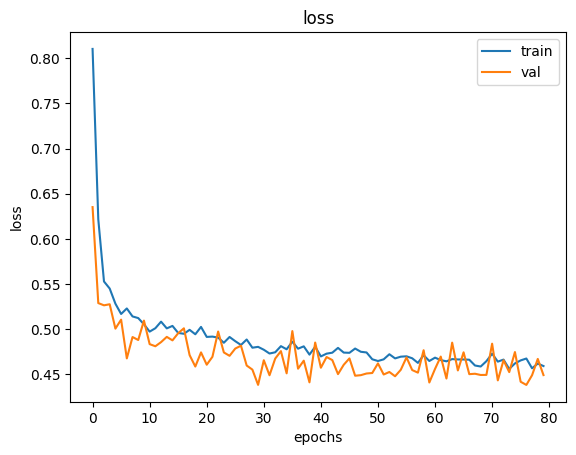

In [157]:
# Your code here ...
utils.plot([loss_train, loss_val], ["train", "val"], xlabel="epochs", ylabel="loss", title="loss")

In [158]:
# test model
def test_model(model, dataloader_test):
    running_acc = 0
    model.eval()
    with torch.no_grad():
        for local_batch, local_labels in dataloader_test:            
            # Your code here ...
            out = model(local_batch)
                    
            [_, predicted] = torch.max(out.data, 1)
            # running_acc += (torch.sum(local_labels == predicted) / local_labels.size()[0]).item()
            running_acc += torch.sum(local_labels == predicted).item()
            # data_num += local_labels.size()[0]
            

    # acc_test = running_acc / len(dataloader_test)   # Your code here ...
    acc_test = running_acc / len(dataloader_test.dataset)
    return acc_test

In [159]:
# Evaluation your model with the test set
# Your code here ...
# 500 epochs, 1024 batch_size: 73.66%
#             2048 batch_size: 63.52%
#             512 batch_size: 75.07% -> lr=1e-4: 62.05% -> lr=1e-2: 43.19% -> split ratio=0.7: 43.19%
#             256 batch_size: 72.96%
# 300 epochs, 1024 batch_size: 68.41%
#             512 batch_size: 74.28%
#             256 batch_size: 62.39%
# 1000 epochs, 512 batch_size: 71.11%
# 600 epochs, 512 batch: 74%
# 800 epochs, 512 batch: 76.72% ->1024: 76.08%
    
acc_test = test_model(model, dataloader_test)# Your code here ...
print(f'Accuracy for test data: {acc_test*100:.2f}%')

Accuracy for test data: 79.78%


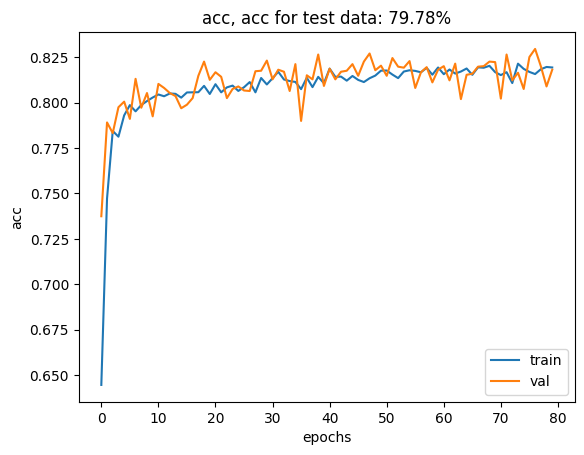

In [160]:
# Your code here ...
# epoch: 30, batch: 64, layer: 3: 64.83
# epoch: 30, batch: 64, layer: 4: 64.07
# epoch: 30, batch: 64, layer: 5: 61.08
# epoch: 30, batch: 64, layer: 6: 66.34
# epoch: 30, batch: 64, layer: 7: 64.35%
# epoch: 30, batch: 64, layer: 8: 66.44
# epoch: 30, batch: 64, layer: 9: 65.72
# epoch: 30, batch: 64, layer: 10: 66.04
# epoch: 30, batch: 64, layer: 11: 61.01

# epoch: 30, batch: 128, layer: 8: 57.43
# epoch: 30, batch: 256, layer: 8: 51.98
# epoch: 30, batch: 518, layer: 8: 52.88
# epoch: 40, batch: 64, layer: 8: 51.86%
# epoch: 50, batch: 64, layer: 8: 60.23
# epoch: 60, batch: 64, layer: 8: 60.63
# epoch: 70, batch: 64, layer: 8: 65.89
# epoch: 80, batch: 64, layer: 8: 65.25
# epoch: 80, batch: 128, layer: 8: 64.14
# epoch: 80, batch: 256, layer: 8: 65.75
# epoch: 80, batch: 518, layer: 8: 60.40
utils.plot([acc_train, acc_val], ["train", "val"], xlabel="epochs", ylabel="acc", title="acc, acc for test data: {:.2f}%".format(acc_test*100))

## 2. Image Quality Classification
The goal of this exercise is to classify images as being either fully-sampled or accelerated and reconstructed with compressed sensing.

## 2.1.	Prepare training data.
### 2.1.1.	Load data
- Label 0: Fully-sampled ground truth
- Label 1: TGV-based compressed sensing

In [756]:
x_train, y_train, x_val, y_val = utils.load_data_ex2()
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(390, 1, 320, 320)
(390,)
(130, 1, 320, 320)
(130,)


### 2.1.2.	Training data
- Zero-mean & one-std Normalization

In [757]:
# Your code here ...
mean_train = np.mean(x_train)
std_train = np.std(x_train)
x_train = (x_train - mean_train) / std_train

mean_val = np.mean(x_val)
std_val = np.std(x_val)
x_val = (x_val - mean_val) / std_val


- Generate dataloaders.
  - Batch size: 10
  - Train: shuffle / Validation & Test: not shuffle
  - Input data: float / label data: long

In [758]:
# Your code here ...
batch_size = 10

x_train = torch.Tensor(x_train).float().to(DEVICE)
y_train = torch.Tensor(y_train).long().to(DEVICE)
print(x_train.shape)
print(y_train.shape)

x_val = torch.Tensor(x_val).float().to(DEVICE)
y_val = torch.Tensor(y_val).long().to(DEVICE)

dataset_train = data_utils.TensorDataset(x_train, y_train)
dataloader_train = data_utils.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
# model will learn the order of the data 

dataset_val = data_utils.TensorDataset(x_val, y_val)
dataloader_val = data_utils.DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

torch.Size([390, 1, 320, 320])
torch.Size([390])


## 2.2.	Build and train CNNs as shown in the lecture. 
- CNN with 4 layers + fully-connected layer

In [759]:
class CNN4layers_FC(nn.Module):
    def __init__(self):
        # Your code here ...
        super(CNN4layers_FC, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 4, (3, 3), padding=(1, 1))
        self.ReLU1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(4, 4, (3, 3), padding=(1, 1))
        self.ReLU2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(4, 4, (3, 3), padding=(1, 1))
        self.ReLU3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.conv4 = nn.Conv2d(4, 4, (3, 3), padding=(1, 1))
        self.ReLU4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(2, 2)
        
        self.flatten = nn.Flatten()
        self.ReLU5 = nn.ReLU()
        self.fc = nn.Linear(1600, 16)
        self.out = nn.Linear(16, 2)
        
        self.LogSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Your code here ...
        
        x = self.conv1(x)
        x = self.ReLU1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.ReLU2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.ReLU3(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.ReLU4(x)
        x = self.pool4(x)
        
        x = self.flatten(x)
        x = self.ReLU5(x)
        x = self.fc(x)
        x = self.out(x)
        x = self.LogSoftmax(x)      

        return x

- CNN with 1 layer + global average pooling

In [760]:
class CNN1layer_global_avg(nn.Module):
    def __init__(self):
        # Your code here ...
        super(CNN1layer_global_avg, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 4, (3, 3), padding=(1, 1))   
        self.ReLU1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
         
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.out = nn.Linear(4, 2)
        self.LogSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):   # (1, 320, 320)
        # Your code here ...
        x = self.conv1(x)   # (4, 320, 320)
        x = self.ReLU1(x)   # (4, 320, 320)
        x = self.pool1(x)   # (4, 160, 160)
        
        x = self.avgpool(x)
        x = x.reshape(x.size()[0], -1)
        x = self.out(x)
        x = self.LogSoftmax(x)
        print(f"output of model: {x.shape}")

        return x

- CNN with  4 layers + global average pooling

In [761]:
class CNN4layers_global_avg(nn.Module):
    def __init__(self):
        # Your code here ...
        super(CNN4layers_global_avg, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 4, (3, 3), padding=(1, 1))
        self.ReLU1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(4, 4, (3, 3), padding=(1, 1))
        self.ReLU2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(4, 4, (3, 3), padding=(1, 1))
        self.ReLU3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.conv4 = nn.Conv2d(4, 4, (3, 3), padding=(1, 1))
        self.ReLU4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(2, 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.out = nn.Linear(4, 2)
        self.LogSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Your code here ...
        x = self.conv1(x)
        x = self.ReLU1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.ReLU2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.ReLU3(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.ReLU4(x)
        x = self.pool4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.size()[0], -1)
        x = self.out(x)
        x = self.LogSoftmax(x)      


        return x

In [762]:
print("CNN4layers_FC")
print(f"The number of parameters: {sum(p.numel() for p in CNN4layers_FC().parameters() if p.requires_grad)}")
print(CNN4layers_FC())
print('==========================================')

print("CNN1layer_global_avg")
print(f"The number of parameters: {sum(p.numel() for p in CNN1layer_global_avg().parameters() if p.requires_grad)}")
print(CNN1layer_global_avg())
print('==========================================')

print("CNN4layers_global_avg")
print(f"The number of parameters: {sum(p.numel() for p in CNN4layers_global_avg().parameters() if p.requires_grad)}")
print(CNN4layers_global_avg())

CNN4layers_FC
The number of parameters: 26134
CNN4layers_FC(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU4): ReLU()
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (ReLU5): ReLU()
  (fc): Linear(in_features=1600, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=2, bias=True)
  (LogSoftmax): LogSoftmax(dim=1)
)
CNN

## 2.4.	Train the network.
- Loss function: Cross entropy loss
- Optimizer: Adam optimizer
- Learning rate: 0.01
- Epochs: 100

### 2.4.1.	CNN with 4 layers + fully-connected layer

In [765]:
torch.manual_seed(123)  # for reproducibility
model1 = CNN4layers_FC()
epochs = 35
lr = 1e-3
# criterion = nn.CrossEntropyLoss()
criterion == nn.BCELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model1.parameters(), lr=lr)
loss_train_model1, acc_train_model1, loss_val_model1, acc_val_model1 = trainer(model1, criterion, optimizer, dataloader_train, dataloader_val, epochs)

# Your code here ...

  0%|          | 0/35 [00:00<?, ?Epoch/s]

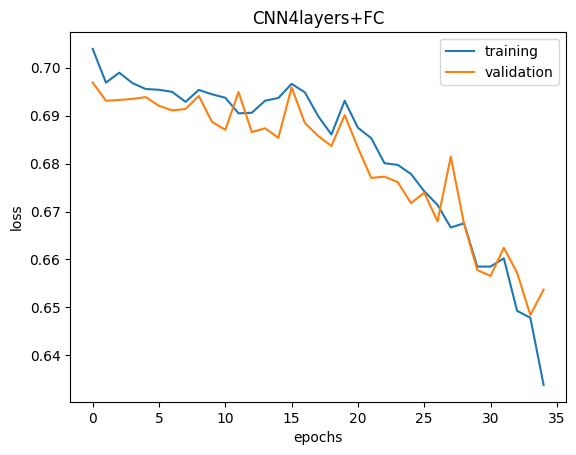

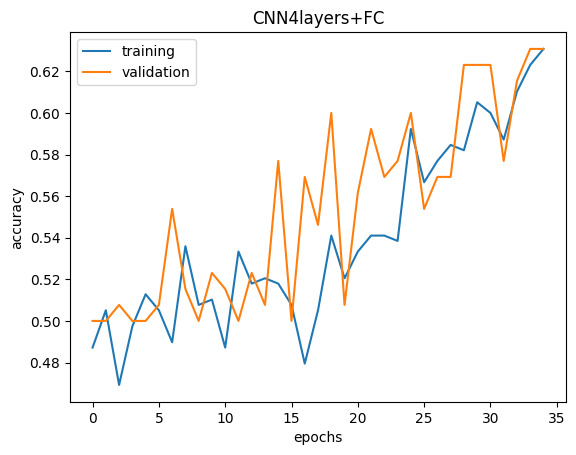

In [766]:
# Your code here ...
utils.plot([loss_train_model1, loss_val_model1], ["training", "validation"], xlabel="epochs", ylabel="loss", title="CNN4layers+FC")
utils.plot([acc_train_model1, acc_val_model1], ["training", "validation"], xlabel="epochs", ylabel="accuracy", title="CNN4layers+FC")

### 2.4.2.	CNN with 1 layers + global average pooling

In [769]:
torch.manual_seed(123)  # for reproducibility
model2 = CNN1layer_global_avg()
epochs = 40
lr = 1e-3
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model2.parameters(), lr=lr)
loss_train_model2, acc_train_model2, loss_val_model2, acc_val_model2 = trainer(model2, criterion, optimizer, dataloader_train, dataloader_val, epochs)
# Your code here ...

  0%|          | 0/40 [00:00<?, ?Epoch/s]

output of model: torch.Size([10, 2])
output of model: torch.Size([10, 2])
output of model: torch.Size([10, 2])
output of model: torch.Size([10, 2])
output of model: torch.Size([10, 2])
output of model: torch.Size([10, 2])
output of model: torch.Size([10, 2])
output of model: torch.Size([10, 2])
output of model: torch.Size([10, 2])
output of model: torch.Size([10, 2])
output of model: torch.Size([10, 2])
output of model: torch.Size([10, 2])
output of model: torch.Size([10, 2])
output of model: torch.Size([10, 2])
output of model: torch.Size([10, 2])
output of model: torch.Size([10, 2])
output of model: torch.Size([10, 2])
output of model: torch.Size([10, 2])
output of model: torch.Size([10, 2])
output of model: torch.Size([10, 2])
output of model: torch.Size([10, 2])
output of model: torch.Size([10, 2])
output of model: torch.Size([10, 2])
output of model: torch.Size([10, 2])
output of model: torch.Size([10, 2])
output of model: torch.Size([10, 2])
output of model: torch.Size([10, 2])
o

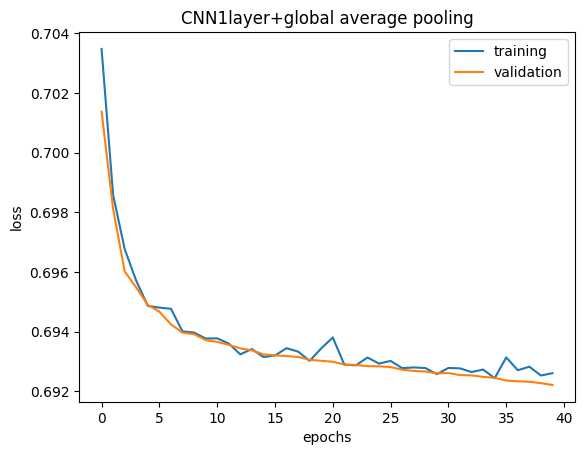

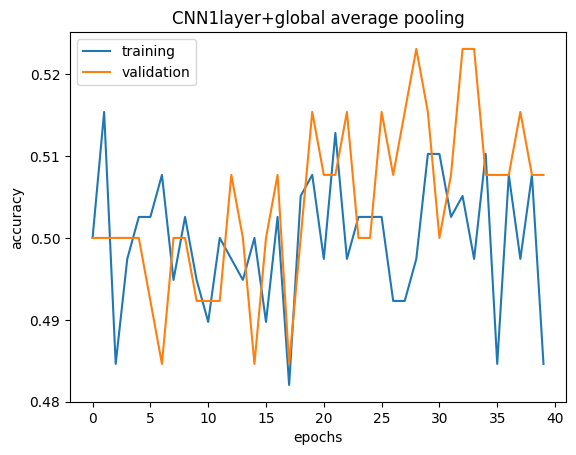

In [770]:
# Your code here ...
utils.plot([loss_train_model2, loss_val_model2], ["training", "validation"], xlabel="epochs", ylabel="loss", title="CNN1layer+global average pooling")
utils.plot([acc_train_model2, acc_val_model2], ["training", "validation"], xlabel="epochs", ylabel="accuracy", title="CNN1layer+global average pooling")

### 2.4.3.	CNN with 4 layers + global average pooling

In [767]:
torch.manual_seed(123)  # for reproducibility
model3 = CNN4layers_global_avg()
epochs = 40
lr = 1e-3
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model3.parameters(), lr=lr)
loss_train_model3, acc_train_model3, loss_val_model3, acc_val_model3 = trainer(model3, criterion, optimizer, dataloader_train, dataloader_val, epochs)
# Your code here ...

  0%|          | 0/40 [00:00<?, ?Epoch/s]

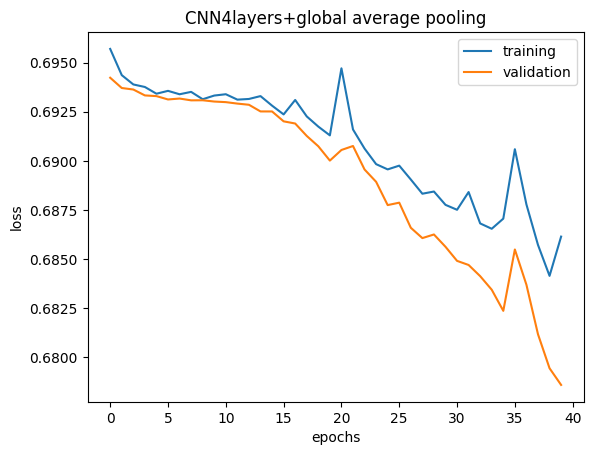

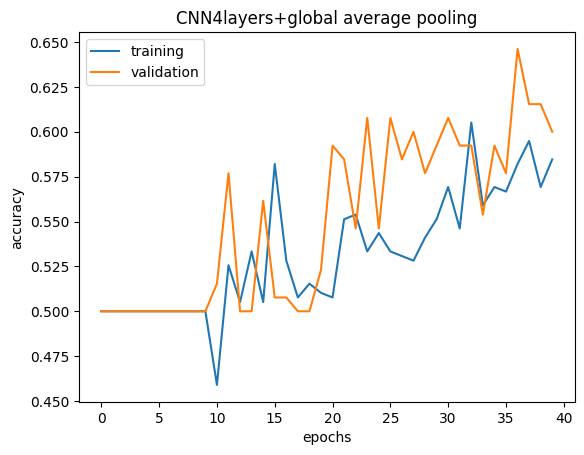

In [768]:
# Your code here ...
utils.plot([loss_train_model3, loss_val_model3], ["training", "validation"], xlabel="epochs", ylabel="loss", title="CNN4layers+global average pooling")
utils.plot([acc_train_model3, acc_val_model3], ["training", "validation"], xlabel="epochs", ylabel="accuracy", title="CNN4layers+global average pooling")

## 2.5.	Evaluate the results of CNN models and the training. Discuss your observations.